# Simple BTC/USD trend following strategy

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Load BTC/USD minute candles
df = pd.read_csv('input/392-crypto-currency-pairs-at-minute-resolution/btcusd.csv')
df['time'] = pd.to_datetime(df['time'], unit = 'ms')
# Use data from 2015 until the end of dataset, that is Sep 2019
df = df[
    (df.time > pd.Timestamp(year = 2015, month = 1, day = 1)) &
    (df.time < pd.Timestamp(year = 2019, month = 1, day = 1))
].reset_index(drop = True)
# Drop the columns we don't use
df.drop(columns = ['high', 'low', 'volume'], inplace = True)
df

,time,open,close
0,2015-01-01 00:01:00,321.64000,322.260000
1,2015-01-01 00:02:00,322.05000,322.050000
2,2015-01-01 00:03:00,321.89000,321.880000
3,2015-01-01 00:04:00,321.84000,321.840000
4,2015-01-01 00:05:00,321.52000,321.500000
...,...,...,...
1685642,2018-12-31 23:55:00,3824.32835,3826.400000
1685643,2018-12-31 23:56:00,3827.70000,3826.400000
1685644,2018-12-31 23:57:00,3827.50000,3828.980152
1685645,2018-12-31 23:58:00,3829.00000,3829.800000


Earns = $32570
Trades = 460
Profit per trade = $70.8


<AxesSubplot:>

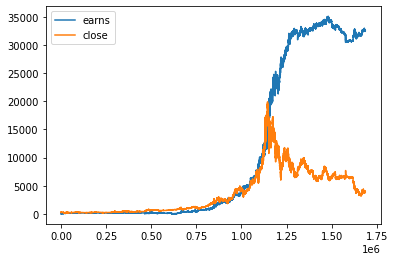

In [3]:
# Trading parameters; windows in minutes
win1 = 30 * 60
win2 = 1 * 60
# 0.01 = 1% price shift within the window
threshold1 = 0.009 
threshold2 = 0.005

# win1 = 300
# win2 = 3600
# threshold1 = 0.01
# threshold2 = -0.005

# Features & Trading logic
df['ma1'] = df['close'].rolling(win1).mean()
df['ma2'] = df['close'].rolling(win2).mean()
df['position'] = np.nan
# When price is above long-term MA and under short-term MA, BUY. 
# And vice versa. Keep +-1 positions, never close.
df.loc[df[
    (df.close > df.ma1 + threshold1 * df.close) & 
    (df.close < df.ma2 - threshold2 * df.close)
].index,'position'] = 1
df.loc[df[
    (df.close < df.ma1 - threshold1 * df.close) & 
    (df.close > df.ma2 + threshold2 * df.close)
].index,'position'] = -1

# Backtest
fees = 0.0010 # exchange transaction fee
df.loc[0, 'position'] = 0
df['position'].fillna(method = 'ffill', inplace = True)
df['nominal'] = - df['position'].diff() * df['close']
df['fees'] = df.position.diff().abs() * fees * df['close']
df['nominal'] -= df['fees']
df['earns'] = df['nominal'].cumsum() + df['position'] * df['close']
earns = df.earns.iloc[-1]

our_trades = df[df.position.diff() != 0].copy()
our_trades['duration'] = our_trades.time.diff()
our_trades['trade_earns'] = our_trades.earns.diff()
print(f'Earns = ${earns:.0f}')
print(f'Trades = {len(our_trades)}')
print(f'Profit per trade = ${earns / len(our_trades):.1f}')
df[['earns','close']].plot()